<a href="https://colab.research.google.com/github/eriksali/DNN_2023_NLP/blob/main/NLP11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSI 5900: Lecture 11 Code Examples

Prof. Steven Wilson, Oakland University

## Logistic Regression for Binary Classification

We will use a dataset of IMDB reviews from:

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). "Learning Word Vectors for Sentiment Analysis." _The 49th Annual Meeting of the Association for Computational Linguistics_ (ACL 2011).

In [ ]:
! wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
! tar -xzf aclImdb_v1.tar.gz

--2023-02-16 23:45:53--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  55.7MB/s    in 1.4s    

2023-02-16 23:45:55 (55.7 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [ ]:
cat aclImdb/README

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

In [ ]:
import glob
pos_train_files = glob.glob('aclImdb/train/pos/*')
neg_train_files = glob.glob('aclImdb/train/neg/*')
print(pos_train_files[:5])

['aclImdb/train/pos/10820_10.txt', 'aclImdb/train/pos/9457_9.txt', 'aclImdb/train/pos/10512_10.txt', 'aclImdb/train/pos/5402_9.txt', 'aclImdb/train/pos/1164_10.txt']


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# only use 1000 data points per class for now to make things faster/simpler
num_files_per_class = 1000
all_train_files = pos_train_files[:num_files_per_class] + neg_train_files[:num_files_per_class]
vectorizer = TfidfVectorizer(input="filename", stop_words="english")
vectors = vectorizer.fit_transform(all_train_files)
vectors

<2000x25122 sparse matrix of type '<class 'numpy.float64'>'
	with 178155 stored elements in Compressed Sparse Row format>

In [ ]:
vectors[0].sum()

10.228179544727185

In [ ]:
X = vectors
y = [1] * num_files_per_class + [0] * num_files_per_class
len(y)

2000

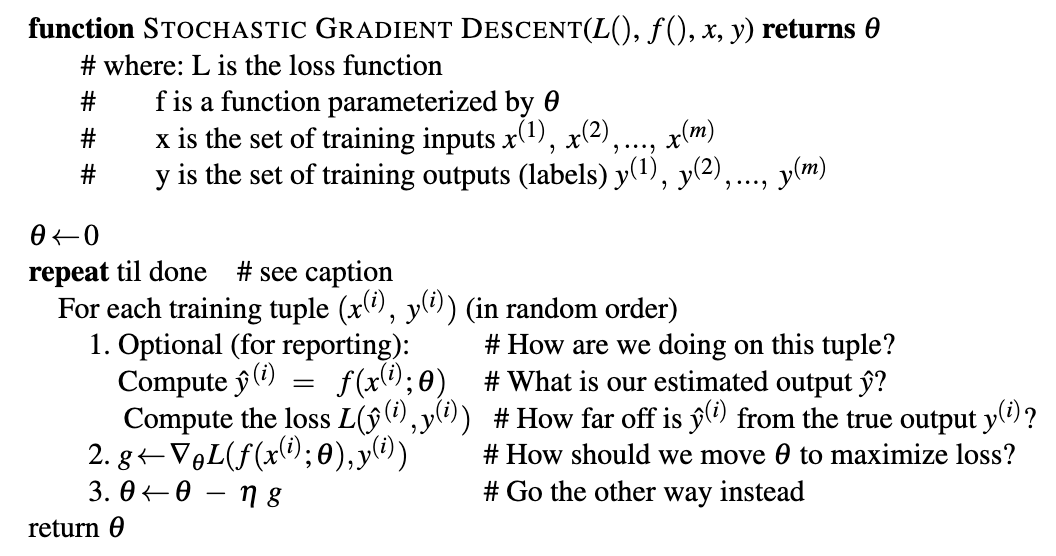

In [ ]:
x_0 = X[0]
w = np.zeros(X.shape[1])
x_0_dense = x_0.todense()
x_0.dot(w)

array([0.])

In [ ]:
import random
import numpy as np
from scipy.special import expit

def sgd_for_lr_with_ce(X, y, num_passes=5, learning_rate = 0.1):

    num_data_points = X.shape[0]

    # Initialize theta -> 0
    num_features = X.shape[1]
    w = np.zeros(num_features)
    b = 0.0

    # repeat until done
    # how to define "done"? let's just make it num passes for now
    # we can also do norm of gradient and when it is < epsilon (something tiny)
    # we stop

    for current_pass in range(num_passes):
        
        # iterate through entire dataset in random order
        order = list(range(num_data_points))
        random.shuffle(order)
        for i in order:

            # compute y-hat for this value of i given y_i and x_i
            x_i = X[i]
            y_i = y[i]

            # need to compute based on w and b
            # sigmoid(w dot x + b)
            z = x_i.dot(w) + b
            y_hat_i = expit(z)

            # for each w (and b), modify by -lr * (y_hat_i - y_i) * x_i
            w = w - learning_rate * (y_hat_i - y_i) * x_i
            b = b - learning_rate * (y_hat_i - y_i)

    # return theta
    return w,b

In [ ]:
w,b = sgd_for_lr_with_ce(X,y)

In [ ]:
w

array([-0.12165094, -0.16962449, -0.05341327, ...,  0.0123329 ,
        0.02744114, -0.04170849])

In [ ]:
# get the predictions
def predict_y_lr(w,b,X,threshold=0.5):

    # use our matrix operation version of the logistic regression model
    # X dot w + b
    # need to make w a column vector so the dimensions line up correctly
    y_hat = X.dot( w.reshape((-1,1)) ) + b

    # then just check if it's > threshold
    preds = np.where(y_hat > threshold,1,0)

    return preds

preds = predict_y_lr(w,b,X)

In [ ]:
preds

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
# compute training set results
from sklearn.metrics import classification_report
w,b = sgd_for_lr_with_ce(X, y, num_passes=10)
y_pred = predict_y_lr(w,b,X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1000
           1       0.99      0.82      0.90      1000

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.90      2000
weighted avg       0.92      0.91      0.90      2000



In [ ]:
# compute for dev set
pos_dev_files = glob.glob('aclImdb/test/pos/*')
neg_dev_files = glob.glob('aclImdb/test/neg/*')
num_dev_files_per_class = 100
all_dev_files = pos_dev_files[:num_dev_files_per_class] + neg_dev_files[:num_dev_files_per_class]
# use the same vectorizer from before! otherwise features won't line up
# don't fit it again, just use it to transform!
X_dev = vectorizer.transform(all_dev_files)
y_dev = [1]* num_dev_files_per_class + [0]* num_dev_files_per_class
# don't need new w and b, these are from out existing model
y_dev_pred = predict_y_lr(w,b,X_dev)
print(classification_report(y_dev, y_dev_pred))

              precision    recall  f1-score   support

           0       0.71      0.96      0.82       100
           1       0.94      0.61      0.74       100

    accuracy                           0.79       200
   macro avg       0.82      0.78      0.78       200
weighted avg       0.82      0.79      0.78       200



## Modify for Multinomial

In [ ]:
import random
import numpy as np

def sgd_for_multinomial_lr_with_ce(X, y, num_passes=5, learning_rate = 0.1):

    num_data_points = X.shape[0]

    # Initialize theta -> 0
    num_features = X.shape[1]
    w = np.zeros(num_features)
    b = 0

    # repeat until done
    # how to define "done"? let's just make it num passes for now
    # we can also do norm of gradient and when it is < epsilon (something tiny)
    # we stop

    for current_pass in range(num_passes):
        
        # iterate through entire dataset in random order
        order = list(range(num_data_points))
        random.shuffle(order)
        for i in order:

            # compute y-hat for this value of i given y_i and x_i
            x_i = X[i]
            y_i = y[i]

            # need to compute based on w and b
            # sigmoid(w dot x + b)
            # y_hat_i = 

            # for each w (and b), modify by -lr * gradient
            # w =
            # b = 

    # return theta
    return w,b